In [ ]:
# Block 1: Login + Lấy dữ liệu VN30 stocks + VN30INDEX
import pandas as pd
from FiinQuantX import FiinSession, BarDataUpdate

# --- Login ---
username = "DSTC_18@fiinquant.vn"
password = "Fiinquant0606"

client = FiinSession(
    username=username,
    password=password
).login()

# --- Lấy danh sách cổ phiếu VN30 ---
tickers_all = list(client.TickerList(ticker="VN30"))
print("Danh sách VN30:", tickers_all)
# --- Lấy dữ liệu history ---
event_history = client.Fetch_Trading_Data(
    realtime=False,
    tickers=tickers_all,
    fields=['open','high','low','close','volume','bu','sd','fs','fn'], 
    adjusted=True,
    by="1d",
    period=1000
)

df_all = event_history.get_data()
print("History ban đầu:", df_all.head())

# --- Callback realtime ---
def onDataUpdate(data: BarDataUpdate):
    global df_all
    df_update = data.to_dataFrame()
    df_all = pd.concat([df_all, df_update])
    df_all = df_all.drop_duplicates()
    print("Realtime update:")
    print(df_update.head())

# --- Bật realtime để nối tiếp dữ liệu ---
event_realtime = client.Fetch_Trading_Data(
    realtime=True,
    tickers=tickers_all,
    fields=['open','high','low','close','volume','bu','sd','fs','fn'], 
    adjusted=True,
    by="1d",
    period=1,
    callback=onDataUpdate
)


Danh sách VN30: ['ACB', 'BID', 'BCM', 'CTG', 'DGC', 'FPT', 'GAS', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'VHM', 'PLX', 'SAB', 'SSB', 'SHB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VIB', 'VIC', 'VJC', 'VNM', 'GVR', 'VPB', 'VRE']
Fetching data, it may take a while. Please wait...
History ban đầu:   ticker         timestamp          open          high           low  \
0    ACB  2021-08-27 00:00  14866.799039  14937.146668  14444.713261   
1    ACB  2021-08-30 00:00  14913.697458  15195.087976  14819.900619   
2    ACB  2021-08-31 00:00  15241.986396  15288.884816  15007.494298   
3    ACB  2021-09-01 00:00  15007.494298  15359.232445  14984.045088   
4    ACB  2021-09-06 00:00  15101.291137  15148.189557  14984.045088   

          close     volume         bu         sd   fs   fn  
0  14890.248248  8069600.0        0.0        0.0  0.0  0.0  
1  15077.841927  8029600.0        0.0        0.0  0.0  0.0  
2  15007.494298  5528600.0        0.0        0.0  0.0  0.0  
3  15007.494298  8715300.0  

In [3]:
# Block 2: Tính các TA Indicators trên df_all (chỉ áp dụng cho cổ phiếu VN30, không tính VN30INDEX)

from FiinQuantX import FiinIndicator


# --- Khởi tạo Indicator ---
fi = client.FiinIndicator()

# EMA
df_all['ema_5']  = fi.ema(df_all['close'], window=5)
df_all['ema_20'] = fi.ema(df_all['close'], window=20)
df_all['ema_50'] = fi.ema(df_all['close'], window=50)

# MACD
df_all['macd']        = fi.macd(df_all['close'], window_fast=12, window_slow=26)
df_all['macd_signal'] = fi.macd_signal(df_all['close'], window_fast=12, window_slow=26, window_sign=9)
df_all['macd_diff']   = fi.macd_diff(df_all['close'], window_fast=12, window_slow=26, window_sign=9)

# RSI
df_all['rsi'] = fi.rsi(df_all['close'], window=14)

# Bollinger Bands
df_all['bollinger_hband'] = fi.bollinger_hband(df_all['close'], window=20, window_dev=2)
df_all['bollinger_lband'] = fi.bollinger_lband(df_all['close'], window=20, window_dev=2)

# ATR
df_all['atr'] = fi.atr(df_all['high'], df_all['low'], df_all['close'], window=14)

# OBV
df_all['obv'] = fi.obv(df_all['close'], df_all['volume'])

# VWAP (Volume Weighted Adjusted Price)
df_all['vwap'] = fi.vwap(df_all['high'], df_all['low'], df_all['close'], df_all['volume'], window=14)

# FVG (nếu cột không tồn tại thì thêm cột mặc định = 0)
if 'fvg' not in df_all.columns:
    df_all['fvg'] = 0
df_all['fvg'] = df_all['fvg'].fillna(0)

# Order Imbalance (OI) = (bu - sd) / (bu + sd)
df_all['oi'] = (df_all['bu'] - df_all['sd']) / (df_all['bu'] + df_all['sd'])

# OI_z = z-score của OI trong 60 phiên gần nhất
df_all['oi_z'] = (df_all['oi'] - df_all['oi'].rolling(60).mean()) / df_all['oi'].rolling(60).std()

# Foreign_z = z-score của dòng tiền ròng ngoại (fn)
df_all['foreign_z'] = (df_all['fn'] - df_all['fn'].rolling(60).mean()) / df_all['fn'].rolling(60).std()

# --- Sort dữ liệu theo ngày ---
df_all = df_all.sort_values(by="timestamp").reset_index(drop=True)

# Ví dụ lọc riêng 1 mã để xem dữ liệu
df_vcb = df_all[df_all['ticker'] == "VCB"].sort_values("timestamp")
print(df_vcb.tail(20))


      ticker         timestamp     open     high      low    close  \
29407    VCB  2025-08-04 00:00  60100.0  61400.0  60000.0  61100.0   
29458    VCB  2025-08-05 00:00  61500.0  63700.0  61200.0  61500.0   
29484    VCB  2025-08-06 00:00  62100.0  62800.0  61900.0  62300.0   
29500    VCB  2025-08-07 00:00  62900.0  62900.0  61300.0  61700.0   
29549    VCB  2025-08-08 00:00  62200.0  63300.0  61600.0  61900.0   
29555    VCB  2025-08-11 00:00  62100.0  63200.0  62100.0  62500.0   
29593    VCB  2025-08-12 00:00  62800.0  64800.0  62700.0  63000.0   
29611    VCB  2025-08-13 00:00  63500.0  63600.0  62000.0  62500.0   
29662    VCB  2025-08-14 00:00  63700.0  66300.0  63300.0  65200.0   
29674    VCB  2025-08-15 00:00  67400.0  67500.0  64200.0  64300.0   
29722    VCB  2025-08-18 00:00  64800.0  65600.0  64000.0  64500.0   
29752    VCB  2025-08-19 00:00  64500.0  65400.0  64200.0  64200.0   
29763    VCB  2025-08-20 00:00  64500.0  64600.0  62200.0  63000.0   
29791    VCB  2025-0

In [5]:
# Block 3: Tải dữ liệu VN30 Index (dùng vào HMM)
import numpy as np 
# --- Tải dữ liệu VN30 Index ---
event_index = client.Fetch_Trading_Data(
    realtime=False,
    tickers=["VN30"],                     # VN30 Index
    fields=['open','high','low','close','volume'],
    adjusted=True,
    by="1d",
    period=1000
)

df_vn30index = event_index.get_data()
df_vn30index = df_vn30index[['timestamp','close']].sort_values("timestamp").reset_index(drop=True)

# --- Tính feature cho HMM ---
df_vn30index['return'] = np.log(df_vn30index['close'] / df_vn30index['close'].shift(1))
df_vn30index['vol']    = df_vn30index['return'].rolling(20).std()
df_vn30index['skew']   = df_vn30index['return'].rolling(20).skew()
df_vn30index['kurt']   = df_vn30index['return'].rolling(20).kurt()

# --- Drop NaN ---
df_vn30index = df_vn30index.dropna().reset_index(drop=True)

print(df_vn30index.head(20))
print(df_vn30index.tail(20))


Fetching data, it may take a while. Please wait...
           timestamp    close    return       vol      skew      kurt
0   2021-09-28 00:00  1451.12  0.008248  0.006361 -0.725421  0.427323
1   2021-09-29 00:00  1450.52 -0.000414  0.006108 -0.683314  0.651515
2   2021-09-30 00:00  1453.76  0.002231  0.006091 -0.791430  0.812978
3   2021-10-01 00:00  1441.83 -0.008240  0.006412 -0.661185  0.094661
4   2021-10-04 00:00  1443.61  0.001234  0.006001 -0.801280  0.369735
5   2021-10-05 00:00  1456.21  0.008690  0.006297 -0.728208  0.112467
6   2021-10-06 00:00  1461.72  0.003777  0.006071 -0.989009  0.888119
7   2021-10-07 00:00  1462.74  0.000698  0.005735 -1.105974  1.213286
8   2021-10-08 00:00  1476.54  0.009390  0.006068 -0.990168  0.888199
9   2021-10-11 00:00  1510.27  0.022587  0.007697  0.271788  2.235796
10  2021-10-12 00:00  1509.57 -0.000464  0.007551  0.236333  2.602306
11  2021-10-13 00:00  1505.55 -0.002667  0.007615  0.371627  2.482862
12  2021-10-14 00:00  1503.38 -0.001442

  File "c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


            timestamp    close    return  regime regime_label
960  2025-08-04 00:00  1653.22  0.023941     2.0      Sideway
961  2025-08-05 00:00  1690.43  0.022258     2.0      Sideway
962  2025-08-06 00:00  1723.31  0.019264     2.0      Sideway
963  2025-08-07 00:00  1734.85  0.006674     2.0      Sideway
964  2025-08-08 00:00  1729.08 -0.003331     2.0      Sideway
965  2025-08-11 00:00  1741.90  0.007387     2.0      Sideway
966  2025-08-12 00:00  1755.25  0.007635     2.0      Sideway
967  2025-08-13 00:00  1753.71 -0.000878     2.0      Sideway
968  2025-08-14 00:00  1793.78  0.022592     2.0      Sideway
969  2025-08-15 00:00  1783.25 -0.005888     2.0      Sideway
970  2025-08-18 00:00  1786.37  0.001748     2.0      Sideway
971  2025-08-19 00:00  1810.46  0.013395     2.0      Sideway
972  2025-08-20 00:00  1828.46  0.009893     2.0      Sideway
973  2025-08-21 00:00  1874.91  0.025087     2.0      Sideway
974  2025-08-22 00:00  1814.02 -0.033015     0.0      Defense
975  202

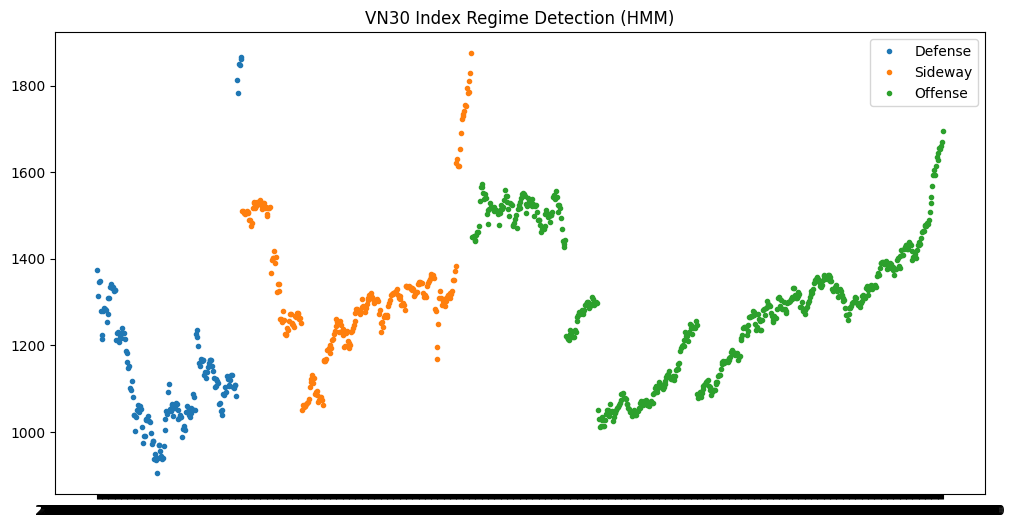

In [9]:
# Block: HMM Regime Detection (VN30 Index)

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# --- Chuẩn bị feature ---
df_feat = df_vn30index[['return','vol','skew','kurt']].dropna().reset_index(drop=True)

# --- Train HMM (3 regimes) ---
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=500, random_state=42)
model.fit(df_feat)

# --- Predict hidden states ---
hidden_states = model.predict(df_feat)
df_vn30index.loc[df_feat.index, 'regime'] = hidden_states

# --- Map regime -> tên ---
# Tính mean return để phân loại bull/sideway/bear
regime_means = df_vn30index.groupby('regime')['return'].mean().sort_values()
mapping = {
    regime_means.index[0]: "Defense",   # Bear (mean return thấp nhất)
    regime_means.index[1]: "Sideway",   # Giữa
    regime_means.index[2]: "Offense"    # Bull (mean return cao nhất)
}
df_vn30index['regime_label'] = df_vn30index['regime'].map(mapping)

# --- In kết quả ---
print(df_vn30index[['timestamp','close','return','regime','regime_label']].tail(20))

# --- Vẽ biểu đồ ---
plt.figure(figsize=(12,6))
for state, label in mapping.items():
    idx = df_vn30index['regime'] == state
    plt.plot(df_vn30index.loc[idx, 'timestamp'], df_vn30index.loc[idx, 'close'], '.', label=label)
plt.legend()
plt.title("VN30 Index Regime Detection (HMM)")
plt.show()


In [10]:
# Block 5: TA-Score (Trend, Momentum, Volume, Volatility, SMC)

import numpy as np

df_ta = df_all.copy()

# --- TrendScore ---
# EMA20 > EMA50 & MACD > Signal -> mạnh
df_ta['trend_score'] = 1 / (1 + np.exp(-(
    ((df_ta['ema_20'] / df_ta['ema_50']) - 1) + 
    (df_ta['macd'] - df_ta['macd_signal'])
)))

# --- MomentumScore ---
# RSI tốt nhất 55–65, giảm dần khi <40 hoặc >70
df_ta['momentum_score'] = np.exp(-((df_ta['rsi']-60)/15)**2)

# --- VolumeScore ---
# 0.5*rank(OBV_slope) + 0.5*rank(OI_z); +0.1 nếu Foreign_z > 0.5
df_ta['obv_slope'] = df_ta.groupby('ticker')['obv'].diff(5)  # slope 5 phiên
df_ta['rank_obv'] = df_ta['obv_slope'].rank(pct=True)
df_ta['rank_oi']  = df_ta['oi_z'].rank(pct=True)
df_ta['volume_score'] = 0.5*df_ta['rank_obv'] + 0.5*df_ta['rank_oi']
df_ta.loc[df_ta['foreign_z'] > 0.5, 'volume_score'] += 0.1
df_ta['volume_score'] = df_ta['volume_score'].clip(0,1)

# --- VolatilityScore ---
# breakout từ squeeze (BBwidth thấp + Close > BBup)
df_ta['bb_width'] = (df_ta['bollinger_hband'] - df_ta['bollinger_lband']) / df_ta['bollinger_lband']
df_ta['volatility_score'] = 0
df_ta.loc[(df_ta['bb_width'] < df_ta['bb_width'].quantile(0.25)) & (df_ta['close'] > df_ta['bollinger_hband']), 'volatility_score'] = 1
df_ta.loc[(df_ta['close'] > df_ta['bollinger_hband']), 'volatility_score'] = 0.5

# --- SMCScore ---
# Nếu có Bullish FVG/OB retest thì cho điểm cao (đơn giản: fvg > 0)
df_ta['smc_score'] = np.where(df_ta['fvg'] > 0, 1, 0)

# --- Merge với regime (VN30 Index) ---
df_ta = df_ta.merge(df_vn30index[['timestamp','regime_label']], on='timestamp', how='left')

# --- Weighted TA Score theo regime ---
def calc_ta_score(row):
    if row['regime_label'] == "Offense":
        return (0.30*row['trend_score'] + 0.25*row['momentum_score'] +
                0.20*row['volume_score'] + 0.10*row['volatility_score'] +
                0.15*row['smc_score'])
    elif row['regime_label'] == "Sideway":
        return (0.20*row['trend_score'] + 0.20*row['momentum_score'] +
                0.25*row['volume_score'] + 0.20*row['volatility_score'] +
                0.15*row['smc_score'])
    elif row['regime_label'] == "Defense":
        return (0.20*row['trend_score'] + 0.15*row['momentum_score'] +
                0.25*row['volume_score'] + 0.20*row['volatility_score'] +
                0.20*row['smc_score'])
    else:
        return np.nan

df_ta['ta_score'] = df_ta.apply(calc_ta_score, axis=1)

# --- Kết quả ---
print(df_ta[['ticker','timestamp','regime_label','trend_score','momentum_score','volume_score','volatility_score','smc_score','ta_score']].tail(20))


      ticker         timestamp regime_label    trend_score  momentum_score  \
29980    HDB  2025-08-29 00:00      Defense   1.000000e+00        0.601707   
29981    HPG  2025-08-29 00:00      Defense   2.590544e-79        0.931317   
29982    LPB  2025-08-29 00:00      Defense   1.000000e+00        0.881007   
29983    MBB  2025-08-29 00:00      Defense   7.459925e-38        0.775696   
29984    VPB  2025-08-29 00:00      Defense   7.866373e-71        0.851082   
29985    MSN  2025-08-29 00:00      Defense  2.274891e-117        0.993231   
29986    SAB  2025-08-29 00:00      Defense   9.398104e-48        0.297045   
29987    SHB  2025-08-29 00:00      Defense   2.615043e-44        0.814224   
29988    SSB  2025-08-29 00:00      Defense   5.522537e-01        0.904327   
29989    SSI  2025-08-29 00:00      Defense   1.000000e+00        0.310853   
29990    STB  2025-08-29 00:00      Defense   5.878565e-52        0.993956   
29991    TCB  2025-08-29 00:00      Defense   8.571311e-19      

In [12]:
# Block 6: Tính FA Score (không phân ngành) từ BCTC đã flatten

import numpy as np
import pandas as pd

# --- Kiểm tra đã login ---
assert 'client' in globals() and client is not None, "Chưa đăng nhập FiinQuant (client is None). Chạy Block 1 trước."

# --- Hàm tiện ích: Lấy dữ liệu ratios dạng phẳng (flatten) ---
def get_fa_dataframe(tickers, latest_year=2024, n_quarters=12, consolidated=True):
    """
    Lấy dữ liệu FA ratios cho nhiều tickers, flatten tất cả các chỉ số ra DataFrame.

    tickers       : list các mã cổ phiếu
    latest_year   : năm gần nhất
    n_quarters    : số quý cần lấy (ví dụ 12 quý = 3 năm gần nhất)
    consolidated  : True = BCTC hợp nhất
    """
    fi_dict = client.FundamentalAnalysis().get_ratios(
        tickers=tickers,
        TimeFilter="Quarterly",
        LatestYear=latest_year,
        NumberOfPeriod=n_quarters,
        Consolidated=consolidated
    )

    records = []
    for item in fi_dict:
        row = {
            "ticker": item["ticker"],
            "year": item["year"],
            "quarter": item["quarter"],
        }
        # flatten toàn bộ nhóm ratios
        for group_name, group_values in item.get("ratios", {}).items():
            for k, v in group_values.items():
                row[k] = v
        records.append(row)

    df = pd.DataFrame(records)
    return df


# --- Lấy dữ liệu FA ratios cho VN30 (12 quý = 3 năm gần nhất) ---
df_fa = get_fa_dataframe(
    tickers=tickers_all,
    latest_year=2024,
    n_quarters=12,           # 3 năm gần nhất
    consolidated=True
)

print("FA raw:", df_fa.head())

# --- Các cột FA được chọn ---
fa_cols = [
    'DebtToEquityRatio','EBITMargin','ROA','ROE','ROIC',
    'BasicEPS','PriceToBook','PriceToEarning',
    'NetRevenueGrowthYoY','GrossProfitGrowthYoY'
]

# --- Sắp xếp để ffill ---
df_fa = df_fa.sort_values(by=["ticker","year","quarter"]).reset_index(drop=True)

# --- Forward fill cho từng ticker ---
df_fa[fa_cols] = df_fa.groupby("ticker")[fa_cols].ffill()

# --- Winsorize + Zscore + MinMax ---
def winsorize_series(s, lower=0.01, upper=0.99):
    q_low, q_high = s.quantile([lower, upper])
    return s.clip(q_low, q_high)

for col in fa_cols:
    if col in df_fa.columns:
        df_fa[col] = df_fa[col].fillna(0)  # nếu vẫn còn thiếu
        df_fa[col] = winsorize_series(df_fa[col])
        if df_fa[col].std(ddof=0) != 0:
            df_fa[col] = (df_fa[col] - df_fa[col].mean()) / df_fa[col].std(ddof=0)
        col_min, col_max = df_fa[col].min(), df_fa[col].max()
        if col_max != col_min:
            df_fa[col] = (df_fa[col] - col_min) / (col_max - col_min)

# --- Công thức FA Score ---
df_fa['fa_score'] = (
      0.15*df_fa.get('ROE', 0)
    + 0.15*df_fa.get('ROA', 0)
    + 0.10*df_fa.get('ROIC', 0)
    + 0.10*df_fa.get('EBITMargin', 0)
    + 0.10*df_fa.get('GrossProfitGrowthYoY', 0)
    + 0.10*df_fa.get('NetRevenueGrowthYoY', 0)
    + 0.10*df_fa.get('BasicEPS', 0)
    - 0.10*df_fa.get('PriceToEarning', 0)
    - 0.05*df_fa.get('PriceToBook', 0)
    - 0.10*df_fa.get('DebtToEquityRatio', 0)
)

# --- Lấy FA Score trung bình 12 quý gần nhất ---
df_fa_final = df_fa.groupby("ticker", as_index=False)['fa_score'].mean()

# --- Sắp xếp giảm dần ---
df_fa_final = df_fa_final.sort_values("fa_score", ascending=False)

print("FA Score final:")
print(df_fa_final.head(20))


FA raw:   ticker  year  quarter  DebtToEquityRatio  EBITMargin  ROA  ROE  ROIC  \
0    ACB  2022        1                NaN         NaN  NaN  NaN   NaN   
1    ACB  2022        2                NaN         NaN  NaN  NaN   NaN   
2    ACB  2022        3                NaN         NaN  NaN  NaN   NaN   
3    ACB  2022        4                NaN         NaN  NaN  NaN   NaN   
4    ACB  2023        1                NaN         NaN  NaN  NaN   NaN   

   BasicEPS  PriceToBook  PriceToEarning  NetRevenueGrowthYoY  \
0       NaN          NaN             NaN                  NaN   
1       NaN          NaN             NaN                  NaN   
2       NaN          NaN             NaN                  NaN   
3       NaN          NaN             NaN                  NaN   
4       NaN          NaN             NaN                  NaN   

   GrossProfitGrowthYoY  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  


In [13]:
# Block 7: Kết hợp TA Score + FA Score thành Final Score

import pandas as pd

# --- Lấy TA Score mới nhất của mỗi ticker ---
df_ta_latest = df_ta.sort_values("timestamp").groupby("ticker").tail(1)
df_ta_latest = df_ta_latest[['ticker','ta_score']]

# --- Merge TA + FA ---
df_scores = pd.merge(
    df_ta_latest,
    df_fa_final[['ticker','fa_score']],
    on="ticker", how="inner"
)

# --- Final Score = 50% TA + 50% FA ---
df_scores['final_score'] = 0.5*df_scores['ta_score'] + 0.5*df_scores['fa_score']

# --- Sort kết quả ---
df_scores = df_scores.sort_values("final_score", ascending=False).reset_index(drop=True)

print("Top 10 cổ phiếu theo Final Score:")
print(df_scores.head(10))

print("Bottom 10 cổ phiếu theo Final Score:")
print(df_scores.tail(10))


Top 10 cổ phiếu theo Final Score:
  ticker  ta_score  fa_score  final_score
0    BID  0.588370  0.094054     0.341212
1    MWG  0.597009  0.083181     0.340095
2    VHM  0.380836  0.276104     0.328470
3    SSI  0.521032  0.124755     0.322894
4    ACB  0.517007  0.094054     0.305530
5    HDB  0.508669  0.094054     0.301362
6    VCB  0.472790  0.094054     0.283422
7    LPB  0.464307  0.094054     0.279181
8    FPT  0.336024  0.209974     0.272999
9    DGC  0.107251  0.421013     0.264132
Bottom 10 cổ phiếu theo Final Score:
   ticker  ta_score  fa_score  final_score
20    STB  0.314460  0.094054     0.204257
21    SSB  0.306005  0.094054     0.200030
22    GAS  0.126652  0.252695     0.189674
23    TCB  0.261038  0.094054     0.177546
24    VJC  0.309649  0.013936     0.161793
25    MBB  0.226086  0.094054     0.160070
26    MSN  0.291706  0.016795     0.154250
27    BCM  0.174157  0.095080     0.134619
28    PLX  0.112727  0.107863     0.110295
29    GVR  0.067991  0.124446     0.0

In [17]:
# Block 8: Entry/Exit Rule (dùng các chỉ báo từ Block 2 + OBV_slope đã tính trước)

# --- Chuẩn bị OBV slope 5 phiên ---
df_ta['obv_slope'] = df_ta.groupby('ticker')['obv'].diff(5)

def check_long_entry(row, regime):
    """Điều kiện Long entry."""
    agree = 0

    # --- Trend ---
    if (row['ema_20'] > row['ema_50']) and (row['macd'] > row['macd_signal']):
        agree += 1

    # --- Momentum ---
    if (50 <= row['rsi'] <= 65):
        agree += 1

    # --- Volatility ---
    if (row['close'] > row['bollinger_hband']):   # breakout
        agree += 1
    elif (row['bollinger_lband'] < row['close'] < row['ema_20']):  # pullback
        agree += 1

    # --- Volume/Flow ---
    if (row['oi_z'] > 0.5) or (row['foreign_z'] > 0) or (row['obv_slope'] > 0):
        agree += 1

    # --- SMC (FVG > 0) ---
    if row['fvg'] > 0:
        agree += 1

    # --- Micro-filter ---
    vwap_cond = (row['close'] >= row['vwap']) and ((row['close']-row['vwap'])/row['close'] <= 0.5*row['atr']/row['close'])

    # --- Regime adjustment ---
    if regime == "Offense" and (agree >= 3) and vwap_cond:
        return True
    elif regime == "Sideway" and ((agree >= 4) or row['fvg'] > 0) and vwap_cond:
        return True
    elif regime == "Defense" and (row['foreign_z'] > 0.5) and (agree >= 4) and vwap_cond:
        return True

    return False


def check_short_entry(row, regime):
    """Điều kiện Short entry."""
    agree = 0

    # --- Trend ---
    if (row['ema_20'] < row['ema_50']) and (row['macd'] < row['macd_signal']):
        agree += 1

    # --- Momentum ---
    if (35 <= row['rsi'] <= 50):
        agree += 1

    # --- Volatility ---
    if (row['close'] < row['bollinger_lband']):  # breakdown
        agree += 1
    elif (row['bollinger_hband'] > row['close'] > row['ema_20']):  # pullback thất bại
        agree += 1

    # --- Volume/Flow ---
    if (row['oi_z'] < -0.5) or (row['foreign_z'] < 0) or (row['obv_slope'] < 0):
        agree += 1

    # --- SMC (FVG < 0) ---
    if row['fvg'] < 0:
        agree += 1

    # --- Micro-filter ---
    vwap_cond = (row['close'] <= row['vwap']) and ((row['vwap']-row['close'])/row['close'] <= 0.5*row['atr']/row['close'])

    # --- Regime adjustment ---
    if regime == "Defense" and (agree >= 3) and vwap_cond:
        return True
    elif regime == "Sideway" and (agree >= 4) and vwap_cond:
        return True
    elif regime == "Offense":
        return False  # Không short khi thị trường offense

    return False


# --- Backtest loop ---
signals = []
for date, group in df_ta.groupby("timestamp"):
    regime = group['regime_label'].iloc[0]  # Regime từ VN30 index
    for _, row in group.iterrows():
        if check_long_entry(row, regime):
            signals.append({"date": date, "ticker": row['ticker'], "signal": "LONG"})
        elif check_short_entry(row, regime):
            signals.append({"date": date, "ticker": row['ticker'], "signal": "SHORT"})

df_signals = pd.DataFrame(signals)
print(df_signals.tail(20))


                 date ticker signal
618  2025-06-23 00:00    HDB   LONG
619  2025-06-24 00:00    GAS   LONG
620  2025-06-24 00:00    HDB   LONG
621  2025-06-24 00:00    ACB   LONG
622  2025-06-27 00:00    LPB   LONG
623  2025-06-30 00:00    SAB   LONG
624  2025-06-30 00:00    LPB   LONG
625  2025-07-01 00:00    HPG   LONG
626  2025-07-01 00:00    MWG   LONG
627  2025-07-01 00:00    LPB   LONG
628  2025-07-03 00:00    MWG   LONG
629  2025-07-10 00:00    DGC   LONG
630  2025-07-11 00:00    LPB   LONG
631  2025-07-17 00:00    BCM   LONG
632  2025-07-21 00:00    VJC   LONG
633  2025-07-21 00:00    SAB   LONG
634  2025-07-22 00:00    SAB   LONG
635  2025-07-25 00:00    VIC   LONG
636  2025-07-25 00:00    GAS   LONG
637  2025-07-28 00:00    PLX   LONG


In [18]:
# Block 9: Exit Rules (TP/SL/Trailing)

def check_exit_long(entry_price, current_price, atr, entry_date, current_date, max_holding=20):
    """
    Điều kiện thoát cho lệnh LONG:
      - Stoploss: giá < entry_price - 1.5*ATR
      - TakeProfit: giá > entry_price + 3*ATR
      - TrailingStop: nếu giá giảm >1.2*ATR từ đỉnh gần nhất
      - Time stop: quá max_holding ngày
    """
    holding_days = (current_date - entry_date).days
    if current_price < entry_price - 1.5*atr:   # SL
        return True, "SL"
    if current_price > entry_price + 3*atr:     # TP
        return True, "TP"
    if current_price < entry_price and (entry_price - current_price) > 1.2*atr:  # trailing stop
        return True, "Trailing"
    if holding_days > max_holding:              # time exit
        return True, "Time"
    return False, None


def check_exit_short(entry_price, current_price, atr, entry_date, current_date, max_holding=20):
    """
    Điều kiện thoát cho lệnh SHORT:
      - Stoploss: giá > entry_price + 1.5*ATR
      - TakeProfit: giá < entry_price - 3*ATR
      - TrailingStop: nếu giá hồi >1.2*ATR từ đáy gần nhất
      - Time stop: quá max_holding ngày
    """
    holding_days = (current_date - entry_date).days
    if current_price > entry_price + 1.5*atr:   # SL
        return True, "SL"
    if current_price < entry_price - 3*atr:     # TP
        return True, "TP"
    if current_price > entry_price and (current_price - entry_price) > 1.2*atr:  # trailing stop
        return True, "Trailing"
    if holding_days > max_holding:              # time exit
        return True, "Time"
    return False, None


In [20]:
# Block 10: Portfolio Optimization (Top 3 cổ phiếu, Score-weight)

import pandas as pd

# --- Gộp TA score (Block 5) và FA score (Block 6) ---
# Dùng giá trị trung bình TA theo ticker
df_ta_score = df_ta.groupby("ticker", as_index=False)['ta_score'].mean()

# Merge với FA score final
df_scores = pd.merge(
    df_ta_score[['ticker','ta_score']],   # từ Block 5
    df_fa_final[['ticker','fa_score']],   # từ Block 6
    on="ticker", how="inner"
)

# --- Final Score = 50% TA + 50% FA ---
df_scores['final_score'] = 0.5*df_scores['ta_score'] + 0.5*df_scores['fa_score']

# --- Ranking cổ phiếu ---
df_scores = df_scores.sort_values("final_score", ascending=False).reset_index(drop=True)

# --- Chọn Top 3 cổ phiếu ---
TOP_N = 3
portfolio = df_scores.head(TOP_N).copy()

# --- Score-weight allocation ---
portfolio['weight'] = portfolio['final_score'] / portfolio['final_score'].sum()

print("===== Portfolio Selected (Top 3) =====")
print(portfolio[['ticker','ta_score','fa_score','final_score','weight']])


===== Portfolio Selected (Top 3) =====
  ticker  ta_score  fa_score  final_score    weight
0    DGC  0.377321  0.421013     0.399167  0.383414
1    VHM  0.376372  0.276104     0.326238  0.313363
2    GAS  0.378665  0.252695     0.315680  0.303222


===== Backtest Performance (Top1 strategy) =====
Final Equity: -15,846
Total Return: -101.58%
CAGR: nan%
Sharpe: 0.28
Max Drawdown: -146.42%
===== Trade Stats =====
Trades: 23
Winrate: 30.43%
Average PnL per trade: 17.28%


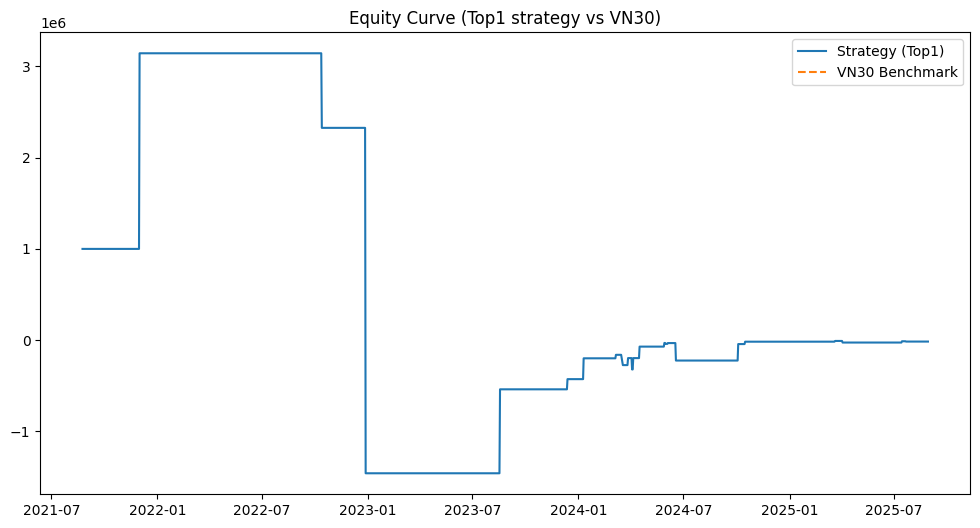

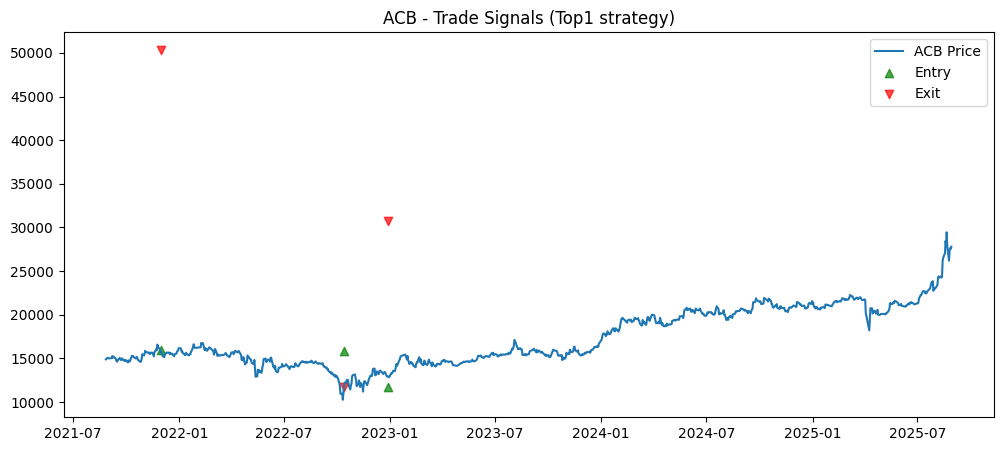

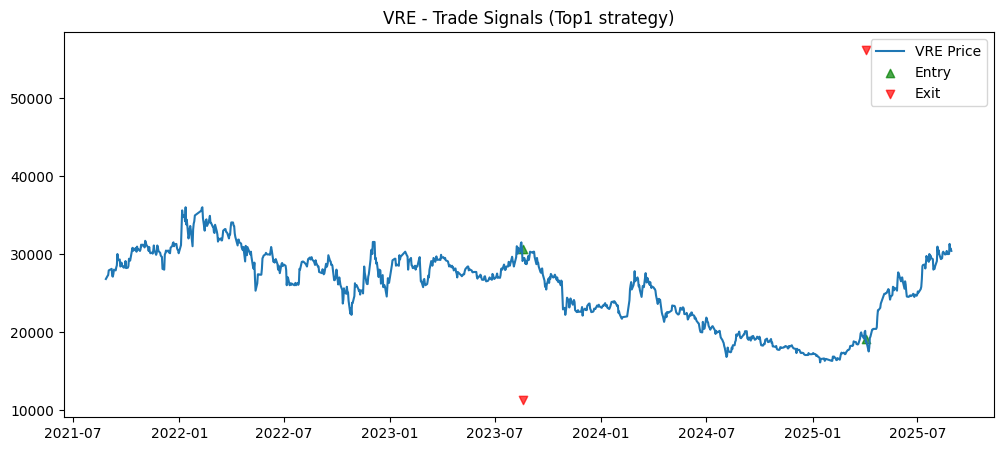

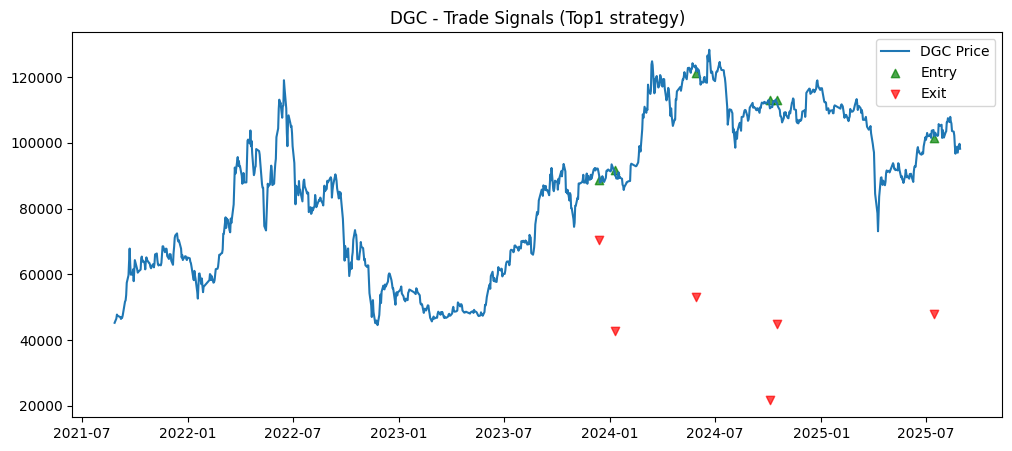

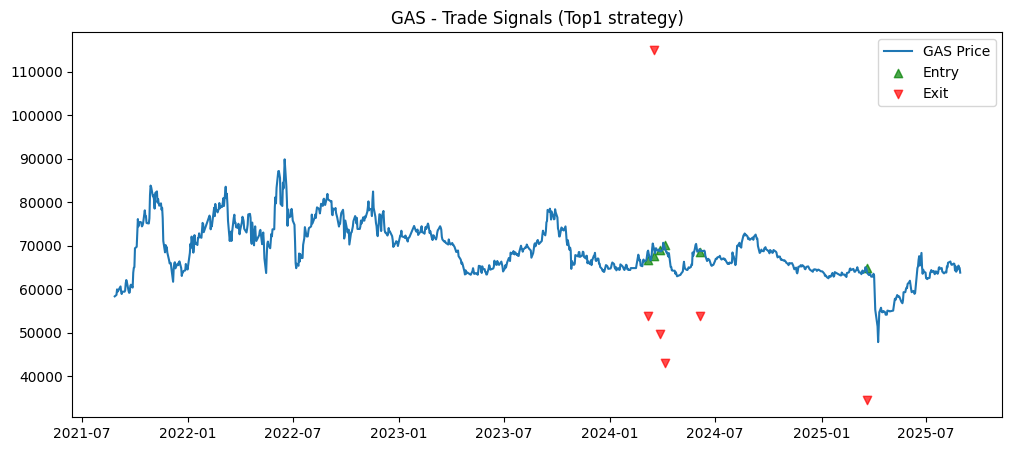

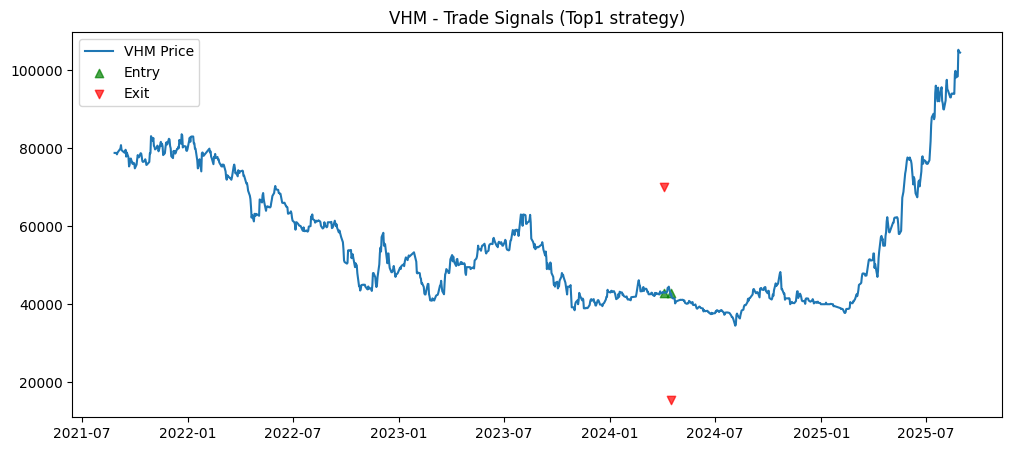

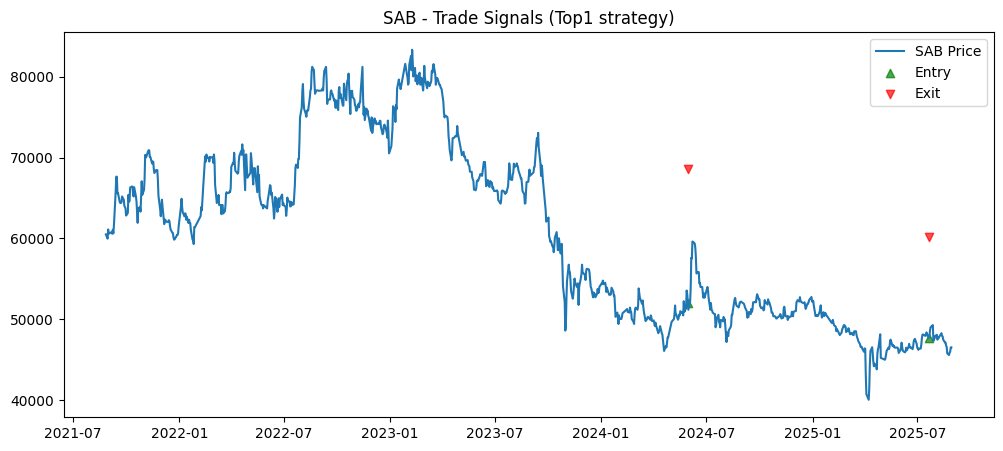

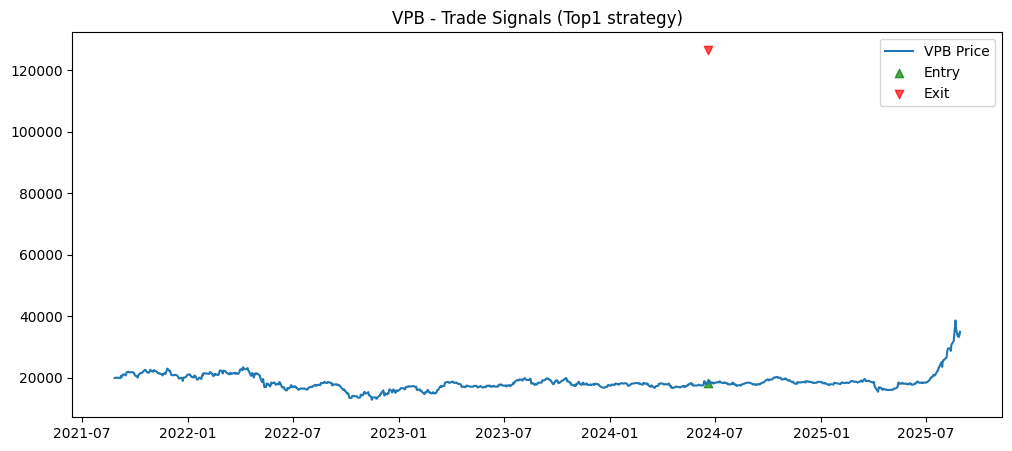

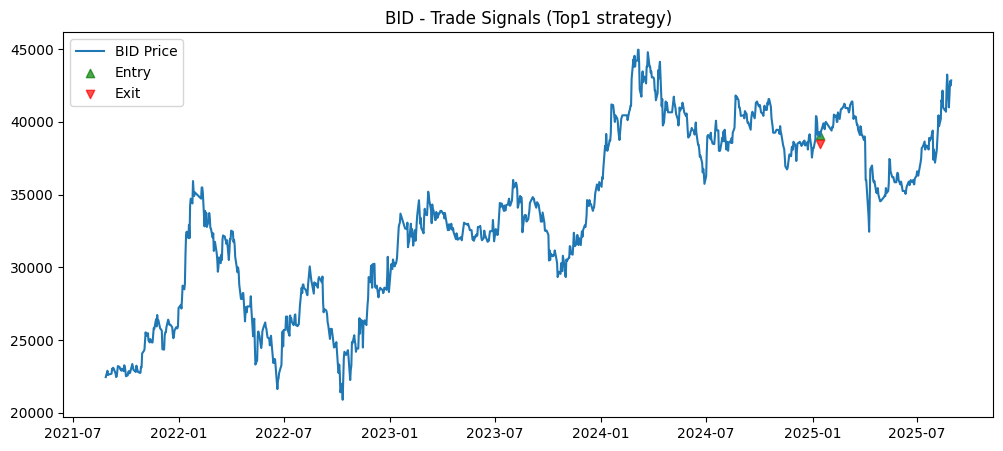

In [24]:
# Block 11: Backtest Strategy với 1 mã duy nhất (final_score cao nhất mỗi ngày)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

initial_capital = 1_000_000

# --- Chuẩn bị dữ liệu ---
df_backtest = df_ta.merge(df_fa_final[['ticker','fa_score']], on='ticker', how='left')
df_backtest['timestamp'] = pd.to_datetime(df_backtest['timestamp'])
df_backtest = df_backtest.sort_values(['timestamp','ticker'])

# --- Final Score ---
df_backtest['final_score'] = 0.5*df_backtest['ta_score'] + 0.5*df_backtest['fa_score']

# --- Daily return ---
df_backtest['return'] = df_backtest.groupby('ticker')['close'].pct_change().fillna(0)

# --- Tín hiệu Entry/Exit từ Block 8 ---
assert 'df_signals' in globals(), "Chưa chạy Block 8 (entry/exit signals)."
df_signals['date'] = pd.to_datetime(df_signals['date'])

# --- Backtest ---
portfolio_history = []
capital = initial_capital
open_trade = None
trade_log = []

for date, daily_data in df_backtest.groupby('timestamp'):
    # chọn mã có final_score cao nhất
    best_row = daily_data.sort_values('final_score', ascending=False).iloc[0]
    ticker = best_row['ticker']
    close_price = best_row['close']
    
    # tín hiệu trong ngày
    sig_today = df_signals[(df_signals['date']==date) & (df_signals['ticker']==ticker)]
    
    # --- Đóng lệnh nếu mã thay đổi hoặc có tín hiệu ngược ---
    if open_trade is not None:
        if open_trade['ticker'] != ticker or (
            not sig_today.empty and sig_today.iloc[0]['signal'] != open_trade['side']
        ):
            pnl = (close_price - open_trade['entry_price'])/open_trade['entry_price']
            if open_trade['side']=="SHORT":
                pnl = -pnl
            capital *= (1+pnl)
            trade_log.append({
                "date": date,
                "ticker": open_trade['ticker'],
                "side": open_trade['side'],
                "entry_price": open_trade['entry_price'],
                "exit_price": close_price,
                "pnl": pnl
            })
            open_trade = None
    
    # --- Mở lệnh mới nếu có tín hiệu đúng ticker top1 ---
    if open_trade is None and not sig_today.empty:
        side = sig_today.iloc[0]['signal']
        open_trade = {"ticker": ticker, "side": side, "entry_price": close_price}
    
    portfolio_history.append({"timestamp": date, "equity": capital})

# --- Đóng lệnh cuối cùng ---
if open_trade is not None:
    last_date = df_backtest['timestamp'].iloc[-1]
    last_price = df_backtest[df_backtest['ticker']==open_trade['ticker']].iloc[-1]['close']
    pnl = (last_price - open_trade['entry_price'])/open_trade['entry_price']
    if open_trade['side']=="SHORT":
        pnl = -pnl
    capital *= (1+pnl)
    trade_log.append({
        "date": last_date,
        "ticker": open_trade['ticker'],
        "side": open_trade['side'],
        "entry_price": open_trade['entry_price'],
        "exit_price": last_price,
        "pnl": pnl
    })

# --- Portfolio Equity ---
df_portfolio = pd.DataFrame(portfolio_history).set_index('timestamp')

# --- Benchmark VN30 ---
df_bench = df_all[df_all['ticker']=="VN30"].copy()
df_bench['timestamp'] = pd.to_datetime(df_bench['timestamp'])
df_bench = df_bench.sort_values("timestamp")
df_bench['bench_return'] = df_bench['close'].pct_change().fillna(0)
df_bench['bench_equity'] = (1+df_bench['bench_return']).cumprod()*initial_capital
df_bench = df_bench.set_index('timestamp')

# --- Merge Equity vs Benchmark ---
df_compare = pd.merge_asof(
    df_portfolio.sort_index().reset_index(),
    df_bench[['bench_equity']].reset_index().sort_values("timestamp"),
    on="timestamp", direction="backward"
).set_index("timestamp")

# --- Performance Metrics ---
final_equity = df_compare['equity'].iloc[-1]
total_return = final_equity/initial_capital - 1
n_years = (df_compare.index[-1] - df_compare.index[0]).days / 365
cagr = (1+total_return)**(1/n_years)-1 if n_years>0 else np.nan
daily_ret = df_compare['equity'].pct_change().dropna()
sharpe = np.sqrt(252)*daily_ret.mean()/daily_ret.std()
drawdown = (df_compare['equity']/df_compare['equity'].cummax()-1).min()

# --- Trade Stats ---
df_trades = pd.DataFrame(trade_log)
n_trades = len(df_trades)
winrate = (df_trades['pnl']>0).mean() if n_trades>0 else 0
avg_pnl = df_trades['pnl'].mean() if n_trades>0 else 0

print("===== Backtest Performance (Top1 strategy) =====")
print(f"Final Equity: {final_equity:,.0f}")
print(f"Total Return: {total_return:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2%}")
print("===== Trade Stats =====")
print(f"Trades: {n_trades}")
print(f"Winrate: {winrate:.2%}")
print(f"Average PnL per trade: {avg_pnl:.2%}")

# --- Plot Equity Curve ---
plt.figure(figsize=(12,6))
plt.plot(df_compare.index, df_compare['equity'], label="Strategy (Top1)")
plt.plot(df_compare.index, df_compare['bench_equity'], '--', label="VN30 Benchmark")
plt.title("Equity Curve (Top1 strategy vs VN30)")
plt.legend()
plt.show()

# --- Plot Entry/Exit trên giá cho ticker đã giao dịch ---
for ticker in df_trades['ticker'].unique():
    df_price = df_backtest[df_backtest['ticker']==ticker].set_index('timestamp')
    plt.figure(figsize=(12,5))
    plt.plot(df_price.index, df_price['close'], label=f"{ticker} Price")
    
    entries = df_trades[df_trades['ticker']==ticker]
    plt.scatter(entries['date'], entries['entry_price'], 
                marker="^", color="green", label="Entry", alpha=0.7)
    plt.scatter(entries['date'], entries['exit_price'], 
                marker="v", color="red", label="Exit", alpha=0.7)
    
    plt.title(f"{ticker} - Trade Signals (Top1 strategy)")
    plt.legend()
    plt.show()
